# Input Impedance Properties of the Model
    > Characterizing the parameter dependency of the input impedance spatial profile 


In [1]:
from single_cell_integration import initialize, load_params # code to run the model: (see content below)
from single_cell_integration import  EXC_SYNAPSES_EQUATIONS, ON_EXC_EVENT
import sys
sys.path.append('../../')
from neural_network_dynamics import nrn, utils
import plot_tools as pt
import matplotlib.pylab as plt
import numpy as np

### Locations where to simulate/record along the dendritic tree

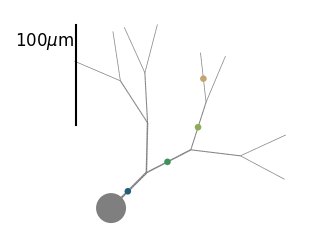

In [2]:
Model = load_params('BRT-parameters.json')
BRT, neuron = initialize(Model)
SEGMENTS = nrn.morpho_analysis.compute_segments(BRT)

vis = pt.nrnvyz(SEGMENTS)
n, N = Model['nseg_per_branch'], Model['branch-number']
BRANCH_LOCS = np.concatenate([np.arange(n+1),
                              1+40*N+np.arange(3*n)])
#BRANCH_LOCS = np.arange(n*N+1)
fig, ax = pt.plt.subplots(1, figsize=(2,2))
vis.plot_segments(ax=ax, color='tab:grey')
#vis.add_dots(ax, BRANCH_LOCS, 1)
BL = BRANCH_LOCS[10::20]
COLORS = [plt.cm.gist_earth((i+1)/(len(BL)+1)) for i in range(len(BL))]
vis.add_dots(ax, BL, 10, color=COLORS)

fig.savefig('../../figures/reduced_model/morpho-with-stim-loc.svg')

In [3]:
BL

array([ 10, 170, 190, 210])

### Run Input Impedance Profile Characterization

In [3]:
from single_cell_integration import EXC_SYNAPSES_EQUATIONS, ON_EXC_EVENT

results = {'Nsyn':6, 'interstim':100}

taus = 5.*nrn.ms
w = 0.4*nrn.nS

for l, loc in enumerate(BL):
    
    case=str(loc)
    results[case] = {}
    
    net, BRT, neuron = None, None, None
    stimulation, ES, M = None, None, None
    
    net, BRT, neuron = initialize(Model, with_network=True)


    spike_IDs, spike_times, synapses = np.empty(0, dtype=int), np.empty(0), np.empty(0, dtype=int)
    for e in range(results['Nsyn']):
        s = np.zeros(e+1)
        spike_times = np.concatenate([spike_times,
                                        (1+e)*results['interstim']+\
                                          np.arange(len(s))*nrn.defaultclock.dt/nrn.ms])
        spike_IDs = np.concatenate([spike_IDs, np.array(s, dtype=int)])

    results[case]['spike_times'] = spike_times
    results[case]['spike_IDs'] = spike_IDs

    stimulation = nrn.SpikeGeneratorGroup(1,
                                          np.array(spike_IDs, dtype=int),
                                          spike_times*nrn.ms)
    net.add(stimulation)
    ES = nrn.Synapses(stimulation, neuron,
                       model=EXC_SYNAPSES_EQUATIONS.format(**Model),
                       on_pre=ON_EXC_EVENT.format(**Model),
                       method='exponential_euler')

    ES.connect(i=0, j=loc)
    net.add(ES)
    # recording and running
    M = nrn.StateMonitor(neuron, ('v'), record=[0, loc])
    net.add(M)
    nrn.run((200+np.max(spike_times))*nrn.ms)
    results[case]['Vm'] = np.array(M.v[0]/nrn.mV)
    results[case]['Vm-loc'] = np.array(M.v[1]/nrn.mV)
    
    results[case]['t'] = np.array(M.t/nrn.ms)

# np.save('results.npy', results)

In [4]:
def build_linear_pred_trace(results, BL):

    # build a dicionary with the individual responses
    
    for l, loc in enumerate(BL):
        
        case=str(loc)

        results[case]['depol-real'] = []
        results[case]['depol-linear'] = []
    
        results['%s-linear-pred' % case] = {'Vm':np.ones(len(results[case]['t']))*results[case]['Vm'][-1],
                                            'Vm-loc':np.ones(len(results[case]['t']))*results[case]['Vm-loc'][-1],
                                            't':results[case]['t']}

        # single syn kernel
        t_cond = (results[case]['t']>results['interstim']) &  (results[case]['t']<(1.9*results['interstim']))
        results['%s-single-syn-kernel' % case] = results[case]['Vm'][t_cond]-results[case]['Vm'][t_cond][0]
        results['%s-single-syn-kernel-loc' % case] = results[case]['Vm-loc'][t_cond]-results[case]['Vm-loc'][t_cond][0]

        for e in range(results['Nsyn']):
            start = ((1+e)*results['interstim'])
            i0 = np.flatnonzero(results[case]['t']>start)[0] 
            N=len(results['%s-single-syn-kernel' % case])
            results['%s-linear-pred' % case]['Vm'][i0:i0+N] += (1+e)*results['%s-single-syn-kernel' % case]
            results['%s-linear-pred' % case]['Vm-loc'][i0:i0+N] += (1+e)*results['%s-single-syn-kernel-loc' % case]
            # compute max depol
            results[case]['depol-real'].append(np.max(results[case]['Vm'][i0:i0+N])-\
                                                   results[case]['Vm'][i0])
            results[case]['depol-linear'].append(np.max(results['%s-linear-pred' % case]['Vm'][i0:i0+N])-\
                                                   results['%s-linear-pred' % case]['Vm'][i0])
            
    return results

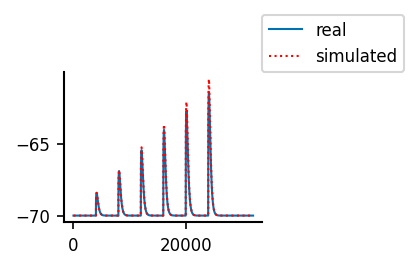

In [6]:
results = build_linear_pred_trace(results, BL)
pt.plt.plot(results['10']['Vm-loc'], label='real')
pt.plt.plot(results['10-linear-pred']['Vm-loc'], 'r:', label='simulated')
pt.plt.legend(loc=(1,1))

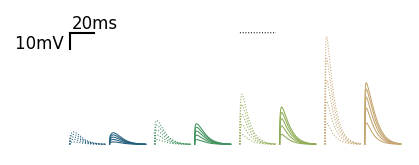

In [7]:
nsyn = 5
length = 30
fig, AX = pt.figure(axes=(4,1), figsize=(0.8,1.3), wspace=0.03, left=0)
for l, loc in enumerate(BL):
    for nsyn in range(1, results['Nsyn']):
        tstart = nsyn*results['interstim']
        tCond = (results[case]['t']>tstart) & (results[case]['t']<(length+tstart))
        case=str(loc)
        AX[l].plot(1.1*length+results[case]['t'][tCond]-results[case]['t'][tCond][0],
                   results[case]['Vm-loc'][tCond], color=COLORS[l], lw=0.5)
        AX[l].plot(results[case]['t'][tCond]-results[case]['t'][tCond][0],
                   results[case+'-linear-pred']['Vm-loc'][tCond], ':', color=COLORS[l], lw=0.5)
    AX[l].axis('off')
AX[2].plot(results[case]['t'][tCond]-results[case]['t'][tCond][0], 0*results[case]['t'][tCond], 'k:', lw=0.5)
pt.set_common_ylims(AX)   
pt.draw_bar_scales(AX[0], Xbar=20, Xbar_label='20ms',
                   Ybar=10, Ybar_label='10mV ')
fig.savefig('../../figures/reduced_model/PSP-at-stim-loc.svg')

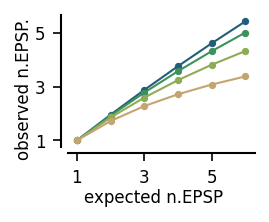

In [8]:
fig, ax = pt.figure(figsize=(1.2,1.4))

#ax.plot(results['10']['depol-linear']/results['10']['depol-real'][0],
#        results['10']['depol-linear']/results['10']['depol-real'][0], 'k:')

for l, loc in enumerate(BL):
    case=str(loc)
    ax.plot(results[case]['depol-linear']/results[case]['depol-real'][0],
                results[case]['depol-real']/results[case]['depol-real'][0],
                'o-', color=COLORS[l])
pt.set_plot(ax, xlabel='expected n.EPSP   ', 
            ylabel='observed n.EPSP.   ', 
            xticks=[1,3,5], yticks=[1,3,5])

fig.savefig('../../figures/reduced_model/summary-at-soma.svg')
#plt.xlim([1,6])
#plt.ylim([1,6])
#results['10']['depol-linear'],

# Redo this by varying the tapering factor

In [5]:
# from the data we get
pv_distal_diam = 0.59
sst_distal_diam = 0.66
pv_tapering_factor = 0.7
sst_tapering_factor = pv_tapering_factor/pv_distal_diam*sst_distal_diam
print('sst_tapering_factor=%.2f' % sst_tapering_factor)

sst_tapering_factor=0.78


In [ ]:
def redo(Model):
    
    n, N = Model['nseg_per_branch'], Model['branch-number']
    BRANCH_LOCS = np.concatenate([np.arange(n+1),
                                  1+40*N+np.arange(3*n)])
    BL = BRANCH_LOCS[10::20]
    
    results = {'Nsyn':6, 'interstim':100}
    
    taus = 5.*nrn.ms
    w = 0.4*nrn.nS
    
    for l, loc in enumerate(BL):
        
        case=str(loc)
        results[case] = {}
        
        net, BRT, neuron = None, None, None
        stimulation, ES, M = None, None, None
        
        net, BRT, neuron = initialize(Model, with_network=True)
    
    
        spike_IDs, spike_times, synapses = np.empty(0, dtype=int), np.empty(0), np.empty(0, dtype=int)
        for e in range(results['Nsyn']):
            s = np.zeros(e+1)
            spike_times = np.concatenate([spike_times,
                                            (1+e)*results['interstim']+\
                                              np.arange(len(s))*nrn.defaultclock.dt/nrn.ms])
            spike_IDs = np.concatenate([spike_IDs, np.array(s, dtype=int)])
    
        results[case]['spike_times'] = spike_times
        results[case]['spike_IDs'] = spike_IDs
    
        stimulation = nrn.SpikeGeneratorGroup(1,
                                              np.array(spike_IDs, dtype=int),
                                              spike_times*nrn.ms)
        net.add(stimulation)
        ES = nrn.Synapses(stimulation, neuron,
                           model=EXC_SYNAPSES_EQUATIONS.format(**Model),
                           on_pre=ON_EXC_EVENT.format(**Model),
                           method='exponential_euler')
    
        ES.connect(i=0, j=loc)
        net.add(ES)
        # recording and running
        M = nrn.StateMonitor(neuron, ('v'), record=[0, loc])
        net.add(M)
        nrn.run((200+np.max(spike_times))*nrn.ms)
        results[case]['Vm'] = np.array(M.v[0]/nrn.mV)
        results[case]['Vm-loc'] = np.array(M.v[1]/nrn.mV)
        
        results[case]['t'] = np.array(M.t/nrn.ms)
    results['BL'] = BL
    results = build_linear_pred_trace(results, BL)
    return results

Model = load_params('BRT-parameters.json')
results = redo(Model)

In [ ]:
fig, ax = pt.figure(figsize=(1.2,1.7))

depol = {}

for tapering, color, key in zip([0.7, 0.8], ['tab:red', 'tab:orange'], ['pv', 'sst']):
    
    Model = load_params('BRT-parameters.json')
    Model['diameter-reduction-factor'] = tapering
    results = redo(Model)
    
    
    depol_linear = np.mean([results[str(l)]['depol-linear'] for l in results['BL']], axis=0)
    depol_real = np.mean([results[str(l)]['depol-real'] for l in results['BL']], axis=0)
    #sdepol_real = np.std([results[str(l)]['depol-real'] for l in results['BL']], axis=0)
    depol[key+'linear'] = depol_linear
    depol[key+'real'] = depol_real
    ax.plot(depol_linear/depol_linear[0], depol_real/depol_linear[0], 'o-',
            color=color, ms=3)
    
ax.plot(depol_linear/depol_linear[0], depol_linear/depol_linear[0], 'k:', lw=1)
pt.set_plot(ax, xlabel='expected n.EPSP   ', 
            ylabel='observed n.EPSP.   ', 
            xticks=[1,3,5], yticks=[1,3,5])

fig.savefig('../../figures/reduced_model/summary-various-tapering.svg')

In [ ]:
NLsst = np.mean(100*(depol['sstreal']-depol['sstlinear'])/depol['sstlinear'])
NLpv = np.mean(100*(depol['pvreal']-depol['pvlinear'])/depol['pvlinear'])
print('variation of linearity: %.1f %%' % np.abs(NLsst-NLpv))